In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import pickle
import time



## USING PREVIOUS DATA

We want to be able to save thing 

IF Pickled = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True

##### set parent directory

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Current Directory: /mnt/c/users/rjmay/code/research_ms/plots
Updated Directory: /mnt/c/users/rjmay/code/research_ms


### Simulation stage

In [4]:
from modules.multi_bounds_v2 import bounds_class
from modules.Bhatt_knn_func import knn_num_calc

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
mean_sep = np.linspace(0, 3, 15 , endpoint = True)

mean_sep = np.insert(mean_sep, 1, .1)
# mean_sep = np.linspace(.05, 3, 2 , endpoint = True)

mean_sep

array([0.        , 0.1       , 0.21428571, 0.42857143, 0.64285714,
       0.85714286, 1.07142857, 1.28571429, 1.5       , 1.71428571,
       1.92857143, 2.14285714, 2.35714286, 2.57142857, 2.78571429,
       3.        ])

In [6]:
bound_obj_lst = []

bound_obj_lst2 = []


if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:

    MC_num = 500

    for i in mean_sep:

        start = time.time()

        mean1 = np.zeros(8)
        covariance1 = np.identity(8)
        mean2 = np.zeros(8)
        mean2[0] = i
        covariance2= np.identity(8)

        
        sample_size= 100
        n0, n1 = sample_size, sample_size
        
        
        k = knn_num_calc(n0, len(mean1))

        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]

        bounds = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, k_nn=k)
        
        bound_obj_lst.append(bounds)
        
        sample_size= 500
        n0, n1 = sample_size, sample_size
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]        
        k = knn_num_calc(n0, len(mean1))

        
        bounds2 = bounds_class("mv_normal", params1, params2, threads =4,  MC_num = MC_num, k_nn =k )

        bound_obj_lst2.append(bounds2)
        
        
        end = time.time()
        
        print("done with ", i, " in ",  end -start )



done with  0.0  in  173.89399337768555
done with  0.1  in  160.04169726371765
done with  0.21428571428571427  in  114.21186709403992
done with  0.42857142857142855  in  124.82525587081909
done with  0.6428571428571428  in  100.26641964912415
done with  0.8571428571428571  in  99.50420665740967
done with  1.0714285714285714  in  111.10729885101318
done with  1.2857142857142856  in  109.63777732849121
done with  1.5  in  99.98554158210754
done with  1.7142857142857142  in  97.73111057281494
done with  1.9285714285714284  in  97.29245042800903
done with  2.142857142857143  in  99.82469367980957
done with  2.357142857142857  in  105.74884963035583
done with  2.571428571428571  in  105.7931170463562
done with  2.7857142857142856  in  99.33428692817688
done with  3.0  in  94.55721640586853


##### Pickling
This is where the data either gets save or loaded

In [7]:
file_path = 'sim_data/means_sep_v3.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


if PICKLED  == False:
    
    objects_to_save = bound_obj_lst, bound_obj_lst2


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, bound_obj_lst2 = loaded_objects

Objects saved to sim_data/means_sep_v3.pkl


### Using the data

may or not be pickled. 

In [9]:
# bound_obj_lst[0].__uppper_bounds_Maha

In [50]:
import pandas as pd

df = pd.DataFrame([obj() for obj in bound_obj_lst], index = mean_sep)

# df

In [33]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 10 + dx, dx)

    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)

    fmin = np.minimum(f0, f1)

    BER = 0.5 * np.sum(fmin * dx)
    
    exact.append(BER)

#     print("BER 2d:", BER)

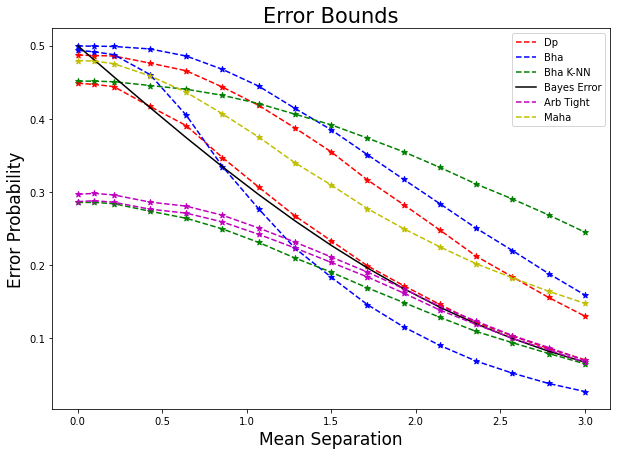

In [49]:
fs = 17

fig, ax = plt.subplots(figsize=(10, 7))

# Plot Dp
ax.plot(df["Dp_lower"], 'r--', label='Dp')
ax.plot(df["Dp_upper"], 'r--')
ax.scatter(df.index, df["Dp_lower"], color='r', marker='*')
ax.scatter(df.index, df["Dp_upper"], color='r', marker='*')

# Plot Bha
ax.plot(df["Bha_lower"], 'b--', label='Bha')
ax.plot(df["Bha_upper"], 'b--')
ax.scatter(df.index, df["Bha_upper"], color='b', marker='*')
ax.scatter(df.index, df["Bha_lower"], color='b', marker='*')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')
ax.scatter(df.index, df["Bha_knn_upper"], color='g', marker='*')
ax.scatter(df.index, df["Bha_knn_lower"], color='g', marker='*')

# Plot Bayes Error
ax.plot(mean_sep, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'm--', label="Arb Tight")
ax.plot(df["tight_upper"], 'm--')
ax.scatter(df.index, df["tight_lower"], color='m', marker='*')
ax.scatter(df.index, df["tight_upper"], color='m', marker='*')

# Plot Maha
ax.plot( df["Maha_upper"], 'y--', label='Maha')
ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

ax.set_xlabel("Mean Separation", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()

plt.show()


In [13]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

tight_l = []
tight_u = []

Bha_knn_l= []
Bha_knn_u =[]
Mah_u =[]

for obj in bound_obj_lst2:
    a,b = obj.get_bounds_dp()
    dp_l.append(np.mean(a))
    dp_u.append(np.mean(b))
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(np.mean(a))
    Bha_u.append(np.mean(b))
    
    a, b = obj.get_bounds_tight()
    tight_l.append(np.mean(a))
    tight_u.append(np.mean(b))

    a,b = obj.get_bounds_Bha_knn()
    Bha_knn_l.append(np.mean(a))
    Bha_knn_u.append(np.mean(b))
    
    a= obj.get_upper_Maha()
    Mah_u.append(np.mean(a))
    
    

In [14]:

Bha_knn_l

[0.3474208138483276,
 0.34675994791434084,
 0.3433427478486461,
 0.331305221161766,
 0.31285065296366726,
 0.28892074377534005,
 0.26465145418304614,
 0.23707621768342355,
 0.2104808823167029,
 0.18412034568259686,
 0.15747335956097386,
 0.13542008334695005,
 0.11441657215517355,
 0.09490519752267769,
 0.07880214852977023,
 0.06379364097023857]

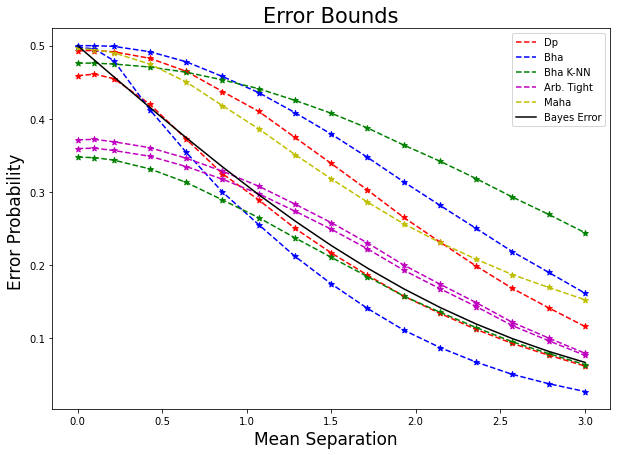

In [15]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)


ax.plot(mean_sep, dp_l, 'r--', label='Dp')
ax.plot(mean_sep, dp_u, 'r--')

ax.scatter(mean_sep, dp_l, color='r', marker='*')
ax.scatter(mean_sep, dp_u, color ='r', marker ='*' )

ax.plot(mean_sep, Bha_l, 'b--', label='Bha')
ax.plot(mean_sep, Bha_u, 'b--')
ax.scatter(mean_sep, Bha_u, color='b', marker='*')
ax.scatter(mean_sep, Bha_l, color ='b', marker ='*' )


ax.plot(mean_sep, Bha_knn_l, 'g--')
ax.plot(mean_sep, Bha_knn_u, 'g--', label='Bha K-NN')
ax.scatter(mean_sep, Bha_knn_u, color='g', marker='*')
ax.scatter(mean_sep, Bha_knn_l, color ='g', marker ='*' )



ax.plot(mean_sep, tight_l, 'm--', label='Arb. Tight')
ax.plot(mean_sep, tight_u, 'm--')
ax.scatter(mean_sep, tight_l, color='m', marker='*')
ax.scatter(mean_sep, tight_u, color ='m', marker ='*' )

ax.plot(mean_sep, Mah_u, 'y--', label='Maha')
ax.scatter(mean_sep, Mah_u, color ='y', marker ='*' )


ax.plot(mean_sep, exact, 'k', label='Bayes Error')


ax.set_xlabel("Mean Separation  ", fontsize = fs)
ax.set_ylabel("Error Probability ", fontsize=fs)
ax.set_title("Error Bounds", fontsize = fs +4)
ax.legend()
# plt.savefig("bounds.png",facecolor=(1,1,1,1))

plt.show()
